### Main points
- Build duration prediction model with new york city taxi dataset
- Log parameters, tag with mlflow
- Parameter tuning with `hyperopt`
- Autolog with mlflow

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464354743487

C:\Users\RD_3\anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\RD_3\anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


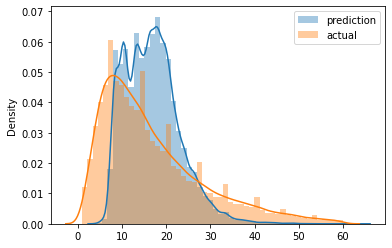

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [9]:
len(df_train), len(df_val)

(73908, 61921)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479614645724615

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    mlflow.set_tag("developer", "godwin")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    # model management : artifact
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle/lin_reg.bin")

In [19]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

C:\Users\RD_3\anaconda3\envs\torch\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [20]:
train, valid = xgb.DMatrix(X_train, label=y_train), xgb.DMatrix(X_val, label=y_val)

In [21]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        
        mlflow.log_metric("rmse", rmse)
    return {'loss': rmse, "status": STATUS_OK}

In [22]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), #exp(-3)-exp(0)
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[11:32:47] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.58280                                                                                           
[1]	validation-rmse:13.32618                                                                                           
[2]	validation-rmse:11.07362                                                                                           
[3]	validation-rmse:9.55091                                                                                            
[4]	validation-rmse:8.54938                                                                                            
[5]	validation-rmse:7.90088                                                                                            
[6]	validation-rmse:7.47985                                                                                            
[7]	v

[134]	validation-rmse:6.60109                                                                                          
[135]	validation-rmse:6.60108                                                                                          
[136]	validation-rmse:6.60107                                                                                          
[137]	validation-rmse:6.60127                                                                                          
[138]	validation-rmse:6.60101                                                                                          
[139]	validation-rmse:6.60114                                                                                          
[140]	validation-rmse:6.60152                                                                                          
[141]	validation-rmse:6.60115                                                                                          
[142]	validation-rmse:6.60111           

[108]	validation-rmse:6.46425                                                                                          
[109]	validation-rmse:6.46268                                                                                          
[110]	validation-rmse:6.46240                                                                                          
[111]	validation-rmse:6.46216                                                                                          
[112]	validation-rmse:6.46180                                                                                          
[113]	validation-rmse:6.46141                                                                                          
[114]	validation-rmse:6.46165                                                                                          
[115]	validation-rmse:6.46140                                                                                          
[116]	validation-rmse:6.46152           

[244]	validation-rmse:6.45664                                                                                          
[245]	validation-rmse:6.45763                                                                                          
[246]	validation-rmse:6.45730                                                                                          
[247]	validation-rmse:6.45701                                                                                          
[248]	validation-rmse:6.45685                                                                                          
[249]	validation-rmse:6.45670                                                                                          
[250]	validation-rmse:6.45676                                                                                          
[251]	validation-rmse:6.45725                                                                                          
[252]	validation-rmse:6.45711           

[24]	validation-rmse:6.55963                                                                                           
[25]	validation-rmse:6.55602                                                                                           
[26]	validation-rmse:6.55338                                                                                           
[27]	validation-rmse:6.55110                                                                                           
[28]	validation-rmse:6.55002                                                                                           
[29]	validation-rmse:6.55053                                                                                           
[30]	validation-rmse:6.54949                                                                                           
[31]	validation-rmse:6.54673                                                                                           
[32]	validation-rmse:6.54598            

[72]	validation-rmse:6.40016                                                                                           
[73]	validation-rmse:6.39954                                                                                           
[74]	validation-rmse:6.39757                                                                                           
[75]	validation-rmse:6.39505                                                                                           
[76]	validation-rmse:6.39260                                                                                           
[77]	validation-rmse:6.39193                                                                                           
[78]	validation-rmse:6.39199                                                                                           
[79]	validation-rmse:6.39272                                                                                           
[80]	validation-rmse:6.39084            

[48]	validation-rmse:6.49671                                                                                           
[49]	validation-rmse:6.49546                                                                                           
[50]	validation-rmse:6.49424                                                                                           
[51]	validation-rmse:6.49328                                                                                           
[52]	validation-rmse:6.49260                                                                                           
[53]	validation-rmse:6.49143                                                                                           
[54]	validation-rmse:6.49005                                                                                           
[55]	validation-rmse:6.48929                                                                                           
[56]	validation-rmse:6.48762            

[184]	validation-rmse:6.39218                                                                                          
[185]	validation-rmse:6.39187                                                                                          
[186]	validation-rmse:6.39166                                                                                          
[187]	validation-rmse:6.39146                                                                                          
[188]	validation-rmse:6.39133                                                                                          
[189]	validation-rmse:6.39101                                                                                          
[190]	validation-rmse:6.39076                                                                                          
[191]	validation-rmse:6.39012                                                                                          
[192]	validation-rmse:6.38990           

[320]	validation-rmse:6.34806                                                                                          
[321]	validation-rmse:6.34821                                                                                          
[322]	validation-rmse:6.34825                                                                                          
[323]	validation-rmse:6.34784                                                                                          
[324]	validation-rmse:6.34754                                                                                          
[325]	validation-rmse:6.34713                                                                                          
[326]	validation-rmse:6.34676                                                                                          
[327]	validation-rmse:6.34649                                                                                          
[328]	validation-rmse:6.34622           

[456]	validation-rmse:6.32595                                                                                          
[457]	validation-rmse:6.32590                                                                                          
[458]	validation-rmse:6.32565                                                                                          
[459]	validation-rmse:6.32550                                                                                          
[460]	validation-rmse:6.32537                                                                                          
[461]	validation-rmse:6.32527                                                                                          
[462]	validation-rmse:6.32489                                                                                          
[463]	validation-rmse:6.32466                                                                                          
[464]	validation-rmse:6.32454           

[592]	validation-rmse:6.31344                                                                                          
[593]	validation-rmse:6.31335                                                                                          
[594]	validation-rmse:6.31341                                                                                          
[595]	validation-rmse:6.31311                                                                                          
[596]	validation-rmse:6.31278                                                                                          
[597]	validation-rmse:6.31278                                                                                          
[598]	validation-rmse:6.31270                                                                                          
[599]	validation-rmse:6.31276                                                                                          
[600]	validation-rmse:6.31268           

[728]	validation-rmse:6.31004                                                                                          
[729]	validation-rmse:6.31009                                                                                          
[730]	validation-rmse:6.31000                                                                                          
[731]	validation-rmse:6.31003                                                                                          
[732]	validation-rmse:6.31068                                                                                          
[733]	validation-rmse:6.31034                                                                                          
[734]	validation-rmse:6.31029                                                                                          
[735]	validation-rmse:6.31040                                                                                          
[736]	validation-rmse:6.31023           

[864]	validation-rmse:6.30560                                                                                          
[865]	validation-rmse:6.30569                                                                                          
[866]	validation-rmse:6.30584                                                                                          
[867]	validation-rmse:6.30585                                                                                          
[868]	validation-rmse:6.30594                                                                                          
[869]	validation-rmse:6.30604                                                                                          
[870]	validation-rmse:6.30669                                                                                          
[871]	validation-rmse:6.30668                                                                                          
[872]	validation-rmse:6.30647           

[90]	validation-rmse:6.57001                                                                                           
[91]	validation-rmse:6.56912                                                                                           
[92]	validation-rmse:6.56847                                                                                           
[93]	validation-rmse:6.56749                                                                                           
[94]	validation-rmse:6.56663                                                                                           
[95]	validation-rmse:6.56583                                                                                           
[96]	validation-rmse:6.56502                                                                                           
[97]	validation-rmse:6.56450                                                                                           
[98]	validation-rmse:6.56388            

[226]	validation-rmse:6.52897                                                                                          
[227]	validation-rmse:6.52888                                                                                          
[228]	validation-rmse:6.52860                                                                                          
[229]	validation-rmse:6.52840                                                                                          
[230]	validation-rmse:6.52831                                                                                          
[231]	validation-rmse:6.52816                                                                                          
[232]	validation-rmse:6.52818                                                                                          
[233]	validation-rmse:6.52798                                                                                          
[234]	validation-rmse:6.52785           

[362]	validation-rmse:6.51574                                                                                          
[363]	validation-rmse:6.51575                                                                                          
[364]	validation-rmse:6.51573                                                                                          
[365]	validation-rmse:6.51567                                                                                          
[366]	validation-rmse:6.51554                                                                                          
[367]	validation-rmse:6.51546                                                                                          
[368]	validation-rmse:6.51536                                                                                          
[369]	validation-rmse:6.51530                                                                                          
[370]	validation-rmse:6.51550           

[498]	validation-rmse:6.51117                                                                                          
[499]	validation-rmse:6.51129                                                                                          
[500]	validation-rmse:6.51118                                                                                          
[501]	validation-rmse:6.51114                                                                                          
[502]	validation-rmse:6.51095                                                                                          
[503]	validation-rmse:6.51084                                                                                          
[504]	validation-rmse:6.51080                                                                                          
[505]	validation-rmse:6.51088                                                                                          
[506]	validation-rmse:6.51099           

[11]	validation-rmse:6.51827                                                                                           
[12]	validation-rmse:6.51432                                                                                           
[13]	validation-rmse:6.51125                                                                                           
[14]	validation-rmse:6.50814                                                                                           
[15]	validation-rmse:6.50755                                                                                           
[16]	validation-rmse:6.50562                                                                                           
[17]	validation-rmse:6.50339                                                                                           
[18]	validation-rmse:6.49900                                                                                           
[19]	validation-rmse:6.49673            

[61]	validation-rmse:6.57102                                                                                           
[62]	validation-rmse:6.57138                                                                                           
[63]	validation-rmse:6.57006                                                                                           
[64]	validation-rmse:6.56974                                                                                           
[65]	validation-rmse:6.56954                                                                                           
[66]	validation-rmse:6.56895                                                                                           
[67]	validation-rmse:6.56831                                                                                           
[68]	validation-rmse:6.56824                                                                                           
[69]	validation-rmse:6.57003            

[53]	validation-rmse:6.50357                                                                                           
[54]	validation-rmse:6.50278                                                                                           
[55]	validation-rmse:6.50172                                                                                           
[56]	validation-rmse:6.50113                                                                                           
[57]	validation-rmse:6.50056                                                                                           
[58]	validation-rmse:6.50025                                                                                           
[59]	validation-rmse:6.50072                                                                                           
[60]	validation-rmse:6.50019                                                                                           
[61]	validation-rmse:6.49957            

[13]	validation-rmse:6.54464                                                                                           
[14]	validation-rmse:6.54104                                                                                           
[15]	validation-rmse:6.53613                                                                                           
[16]	validation-rmse:6.53355                                                                                           
[17]	validation-rmse:6.52872                                                                                           
[18]	validation-rmse:6.52625                                                                                           
[19]	validation-rmse:6.52198                                                                                           
[20]	validation-rmse:6.51554                                                                                           
[21]	validation-rmse:6.51026            

[149]	validation-rmse:6.35640                                                                                          
[150]	validation-rmse:6.35590                                                                                          
[151]	validation-rmse:6.35532                                                                                          
[152]	validation-rmse:6.35477                                                                                          
[153]	validation-rmse:6.35399                                                                                          
[154]	validation-rmse:6.35309                                                                                          
[155]	validation-rmse:6.35240                                                                                          
[156]	validation-rmse:6.35243                                                                                          
[157]	validation-rmse:6.35166           

[285]	validation-rmse:6.31724                                                                                          
[286]	validation-rmse:6.31740                                                                                          
[287]	validation-rmse:6.31790                                                                                          
[288]	validation-rmse:6.31768                                                                                          
[289]	validation-rmse:6.31730                                                                                          
[290]	validation-rmse:6.31737                                                                                          
[291]	validation-rmse:6.31717                                                                                          
[292]	validation-rmse:6.31600                                                                                          
[293]	validation-rmse:6.31604           

[421]	validation-rmse:6.31014                                                                                          
[422]	validation-rmse:6.31009                                                                                          
[423]	validation-rmse:6.31035                                                                                          
[424]	validation-rmse:6.31020                                                                                          
[425]	validation-rmse:6.31055                                                                                          
[426]	validation-rmse:6.31070                                                                                          
[427]	validation-rmse:6.31088                                                                                          
[428]	validation-rmse:6.31118                                                                                          
[11:40:18] WARNING: c:\ci\xgboost-split_

[126]	validation-rmse:6.52575                                                                                          
[127]	validation-rmse:6.52524                                                                                          
[128]	validation-rmse:6.52488                                                                                          
[129]	validation-rmse:6.52465                                                                                          
[130]	validation-rmse:6.52434                                                                                          
[131]	validation-rmse:6.52395                                                                                          
[132]	validation-rmse:6.52357                                                                                          
[133]	validation-rmse:6.52280                                                                                          
[134]	validation-rmse:6.52221           

[262]	validation-rmse:6.47392                                                                                          
[263]	validation-rmse:6.47381                                                                                          
[264]	validation-rmse:6.47348                                                                                          
[265]	validation-rmse:6.47303                                                                                          
[266]	validation-rmse:6.47284                                                                                          
[267]	validation-rmse:6.47252                                                                                          
[268]	validation-rmse:6.47201                                                                                          
[269]	validation-rmse:6.47158                                                                                          
[270]	validation-rmse:6.47121           

[398]	validation-rmse:6.44017                                                                                          
[399]	validation-rmse:6.43997                                                                                          
[400]	validation-rmse:6.43991                                                                                          
[401]	validation-rmse:6.43978                                                                                          
[402]	validation-rmse:6.43958                                                                                          
[403]	validation-rmse:6.43937                                                                                          
[404]	validation-rmse:6.43919                                                                                          
[405]	validation-rmse:6.43926                                                                                          
[406]	validation-rmse:6.43895           

[534]	validation-rmse:6.41391                                                                                          
[535]	validation-rmse:6.41357                                                                                          
[536]	validation-rmse:6.41324                                                                                          
[537]	validation-rmse:6.41298                                                                                          
[538]	validation-rmse:6.41281                                                                                          
[539]	validation-rmse:6.41269                                                                                          
[540]	validation-rmse:6.41258                                                                                          
[541]	validation-rmse:6.41238                                                                                          
[542]	validation-rmse:6.41204           

[670]	validation-rmse:6.39197                                                                                          
[671]	validation-rmse:6.39174                                                                                          
[672]	validation-rmse:6.39147                                                                                          
[673]	validation-rmse:6.39122                                                                                          
[674]	validation-rmse:6.39110                                                                                          
[675]	validation-rmse:6.39102                                                                                          
[676]	validation-rmse:6.39092                                                                                          
[677]	validation-rmse:6.39082                                                                                          
[678]	validation-rmse:6.39084           

[806]	validation-rmse:6.37426                                                                                          
[807]	validation-rmse:6.37417                                                                                          
[808]	validation-rmse:6.37394                                                                                          
[809]	validation-rmse:6.37376                                                                                          
[810]	validation-rmse:6.37364                                                                                          
[811]	validation-rmse:6.37360                                                                                          
[812]	validation-rmse:6.37350                                                                                          
[813]	validation-rmse:6.37338                                                                                          
[814]	validation-rmse:6.37327           

[942]	validation-rmse:6.35911                                                                                          
[943]	validation-rmse:6.35904                                                                                          
[944]	validation-rmse:6.35911                                                                                          
[945]	validation-rmse:6.35915                                                                                          
[946]	validation-rmse:6.35895                                                                                          
[947]	validation-rmse:6.35893                                                                                          
[948]	validation-rmse:6.35884                                                                                          
[949]	validation-rmse:6.35885                                                                                          
[950]	validation-rmse:6.35875           

[76]	validation-rmse:6.72743                                                                                           
[77]	validation-rmse:6.72536                                                                                           
[78]	validation-rmse:6.72336                                                                                           
[79]	validation-rmse:6.72150                                                                                           
[80]	validation-rmse:6.71980                                                                                           
[81]	validation-rmse:6.71851                                                                                           
[82]	validation-rmse:6.71696                                                                                           
[83]	validation-rmse:6.71551                                                                                           
[84]	validation-rmse:6.71379            

[212]	validation-rmse:6.68473                                                                                          
[213]	validation-rmse:6.68470                                                                                          
[214]	validation-rmse:6.68476                                                                                          
[215]	validation-rmse:6.68467                                                                                          
[216]	validation-rmse:6.68459                                                                                          
[217]	validation-rmse:6.68456                                                                                          
[218]	validation-rmse:6.68449                                                                                          
[219]	validation-rmse:6.68443                                                                                          
[220]	validation-rmse:6.68439           

[348]	validation-rmse:6.68133                                                                                          
[349]	validation-rmse:6.68128                                                                                          
[350]	validation-rmse:6.68128                                                                                          
[351]	validation-rmse:6.68134                                                                                          
[352]	validation-rmse:6.68133                                                                                          
[353]	validation-rmse:6.68119                                                                                          
[354]	validation-rmse:6.68115                                                                                          
[355]	validation-rmse:6.68111                                                                                          
[356]	validation-rmse:6.68115           

[484]	validation-rmse:6.67903                                                                                          
[485]	validation-rmse:6.67900                                                                                          
[486]	validation-rmse:6.67893                                                                                          
[487]	validation-rmse:6.67888                                                                                          
[488]	validation-rmse:6.67888                                                                                          
[489]	validation-rmse:6.67886                                                                                          
[490]	validation-rmse:6.67888                                                                                          
[491]	validation-rmse:6.67881                                                                                          
[492]	validation-rmse:6.67879           

[620]	validation-rmse:6.67560                                                                                          
[621]	validation-rmse:6.67562                                                                                          
[622]	validation-rmse:6.67555                                                                                          
[623]	validation-rmse:6.67554                                                                                          
[624]	validation-rmse:6.67554                                                                                          
[625]	validation-rmse:6.67559                                                                                          
[626]	validation-rmse:6.67553                                                                                          
[627]	validation-rmse:6.67549                                                                                          
[628]	validation-rmse:6.67549           

[756]	validation-rmse:6.67495                                                                                          
[757]	validation-rmse:6.67495                                                                                          
[758]	validation-rmse:6.67510                                                                                          
[759]	validation-rmse:6.67510                                                                                          
[760]	validation-rmse:6.67509                                                                                          
[761]	validation-rmse:6.67511                                                                                          
[762]	validation-rmse:6.67515                                                                                          
[763]	validation-rmse:6.67519                                                                                          
[764]	validation-rmse:6.67520           

[95]	validation-rmse:6.42443                                                                                           
[96]	validation-rmse:6.42356                                                                                           
[97]	validation-rmse:6.42311                                                                                           
[98]	validation-rmse:6.42263                                                                                           
[99]	validation-rmse:6.42219                                                                                           
[100]	validation-rmse:6.42160                                                                                          
[101]	validation-rmse:6.42110                                                                                          
[102]	validation-rmse:6.42014                                                                                          
[103]	validation-rmse:6.41977           

[231]	validation-rmse:6.37890                                                                                          
[232]	validation-rmse:6.37872                                                                                          
[233]	validation-rmse:6.37832                                                                                          
[234]	validation-rmse:6.37810                                                                                          
[235]	validation-rmse:6.37767                                                                                          
[236]	validation-rmse:6.37748                                                                                          
[237]	validation-rmse:6.37770                                                                                          
[238]	validation-rmse:6.37718                                                                                          
[239]	validation-rmse:6.37716           

[367]	validation-rmse:6.36506                                                                                          
[368]	validation-rmse:6.36503                                                                                          
[369]	validation-rmse:6.36502                                                                                          
[370]	validation-rmse:6.36491                                                                                          
[371]	validation-rmse:6.36476                                                                                          
[372]	validation-rmse:6.36486                                                                                          
[373]	validation-rmse:6.36446                                                                                          
[374]	validation-rmse:6.36416                                                                                          
[375]	validation-rmse:6.36397           

[53]	validation-rmse:6.50102                                                                                           
[54]	validation-rmse:6.49953                                                                                           
[55]	validation-rmse:6.49875                                                                                           
[56]	validation-rmse:6.49746                                                                                           
[57]	validation-rmse:6.49698                                                                                           
[58]	validation-rmse:6.49572                                                                                           
[59]	validation-rmse:6.49535                                                                                           
[60]	validation-rmse:6.49427                                                                                           
[61]	validation-rmse:6.49333            

[189]	validation-rmse:6.42119                                                                                          
[190]	validation-rmse:6.42114                                                                                          
[191]	validation-rmse:6.42121                                                                                          
[192]	validation-rmse:6.42145                                                                                          
[193]	validation-rmse:6.42103                                                                                          
[194]	validation-rmse:6.42081                                                                                          
[195]	validation-rmse:6.42079                                                                                          
[196]	validation-rmse:6.42022                                                                                          
[197]	validation-rmse:6.41966           

[325]	validation-rmse:6.39134                                                                                          
[326]	validation-rmse:6.39109                                                                                          
[327]	validation-rmse:6.39077                                                                                          
[328]	validation-rmse:6.39023                                                                                          
[329]	validation-rmse:6.38969                                                                                          
[330]	validation-rmse:6.38977                                                                                          
[331]	validation-rmse:6.38954                                                                                          
[332]	validation-rmse:6.38905                                                                                          
[333]	validation-rmse:6.38910           

[461]	validation-rmse:6.37590                                                                                          
[462]	validation-rmse:6.37585                                                                                          
[463]	validation-rmse:6.37595                                                                                          
[464]	validation-rmse:6.37541                                                                                          
[465]	validation-rmse:6.37552                                                                                          
[466]	validation-rmse:6.37637                                                                                          
[467]	validation-rmse:6.37642                                                                                          
[468]	validation-rmse:6.37747                                                                                          
[469]	validation-rmse:6.37637           

[597]	validation-rmse:6.37328                                                                                          
[598]	validation-rmse:6.37329                                                                                          
[599]	validation-rmse:6.37315                                                                                          
[600]	validation-rmse:6.37316                                                                                          
[601]	validation-rmse:6.37338                                                                                          
[602]	validation-rmse:6.37344                                                                                          
[603]	validation-rmse:6.37332                                                                                          
[604]	validation-rmse:6.37309                                                                                          
[605]	validation-rmse:6.37322           

[93]	validation-rmse:6.46550                                                                                           
[94]	validation-rmse:6.46614                                                                                           
[95]	validation-rmse:6.46683                                                                                           
[96]	validation-rmse:6.46690                                                                                           
[97]	validation-rmse:6.46782                                                                                           
[98]	validation-rmse:6.47053                                                                                           
[99]	validation-rmse:6.47134                                                                                           
[100]	validation-rmse:6.47107                                                                                          
[101]	validation-rmse:6.47213           

[110]	validation-rmse:6.51989                                                                                          
[111]	validation-rmse:6.51896                                                                                          
[112]	validation-rmse:6.51863                                                                                          
[113]	validation-rmse:6.51823                                                                                          
[114]	validation-rmse:6.51756                                                                                          
[115]	validation-rmse:6.51717                                                                                          
[116]	validation-rmse:6.51684                                                                                          
[117]	validation-rmse:6.51635                                                                                          
[118]	validation-rmse:6.51587           

[246]	validation-rmse:6.48990                                                                                          
[247]	validation-rmse:6.48965                                                                                          
[248]	validation-rmse:6.48961                                                                                          
[249]	validation-rmse:6.48965                                                                                          
[250]	validation-rmse:6.48963                                                                                          
[251]	validation-rmse:6.48941                                                                                          
[252]	validation-rmse:6.48928                                                                                          
[253]	validation-rmse:6.48918                                                                                          
[254]	validation-rmse:6.48920           

[382]	validation-rmse:6.48089                                                                                          
[383]	validation-rmse:6.48075                                                                                          
[384]	validation-rmse:6.48064                                                                                          
[385]	validation-rmse:6.48050                                                                                          
[386]	validation-rmse:6.48037                                                                                          
[387]	validation-rmse:6.48028                                                                                          
[388]	validation-rmse:6.48007                                                                                          
[389]	validation-rmse:6.48004                                                                                          
[390]	validation-rmse:6.47993           

[518]	validation-rmse:6.47866                                                                                          
[519]	validation-rmse:6.47867                                                                                          
[520]	validation-rmse:6.47877                                                                                          
[521]	validation-rmse:6.47870                                                                                          
[522]	validation-rmse:6.47864                                                                                          
[523]	validation-rmse:6.47843                                                                                          
[524]	validation-rmse:6.47833                                                                                          
[525]	validation-rmse:6.47825                                                                                          
[526]	validation-rmse:6.47817           

[63]	validation-rmse:6.57753                                                                                           
[64]	validation-rmse:6.57728                                                                                           
[65]	validation-rmse:6.57651                                                                                           
[66]	validation-rmse:6.57595                                                                                           
[67]	validation-rmse:6.57562                                                                                           
[68]	validation-rmse:6.57498                                                                                           
[69]	validation-rmse:6.57465                                                                                           
[70]	validation-rmse:6.57424                                                                                           
[71]	validation-rmse:6.57384            

[199]	validation-rmse:6.55756                                                                                          
[200]	validation-rmse:6.55765                                                                                          
[201]	validation-rmse:6.55755                                                                                          
[202]	validation-rmse:6.55747                                                                                          
[203]	validation-rmse:6.55756                                                                                          
[204]	validation-rmse:6.55751                                                                                          
[205]	validation-rmse:6.55760                                                                                          
[206]	validation-rmse:6.55758                                                                                          
[207]	validation-rmse:6.55756           

[11:48:55] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:9.92975                                                                                            
[1]	validation-rmse:7.28385                                                                                            
[2]	validation-rmse:6.73454                                                                                            
[3]	validation-rmse:6.59619                                                                                            
[4]	validation-rmse:6.54819                                                                                            
[5]	validation-rmse:6.53026                                                                                            
[6]	validation-rmse:6.52265                                                                                            
[7]	v

[23]	validation-rmse:7.77498                                                                                           
[24]	validation-rmse:7.65553                                                                                           
[25]	validation-rmse:7.54940                                                                                           
[26]	validation-rmse:7.45357                                                                                           
[27]	validation-rmse:7.36805                                                                                           
[28]	validation-rmse:7.29192                                                                                           
[29]	validation-rmse:7.22386                                                                                           
[30]	validation-rmse:7.16152                                                                                           
[31]	validation-rmse:7.10671            

[159]	validation-rmse:6.52592                                                                                          
[160]	validation-rmse:6.52575                                                                                          
[161]	validation-rmse:6.52555                                                                                          
[162]	validation-rmse:6.52515                                                                                          
[163]	validation-rmse:6.52486                                                                                          
[164]	validation-rmse:6.52415                                                                                          
[165]	validation-rmse:6.52399                                                                                          
[166]	validation-rmse:6.52365                                                                                          
[167]	validation-rmse:6.52337           

[295]	validation-rmse:6.48948                                                                                          
[296]	validation-rmse:6.48925                                                                                          
[297]	validation-rmse:6.48920                                                                                          
[298]	validation-rmse:6.48900                                                                                          
[299]	validation-rmse:6.48879                                                                                          
[300]	validation-rmse:6.48875                                                                                          
[301]	validation-rmse:6.48866                                                                                          
[302]	validation-rmse:6.48850                                                                                          
[303]	validation-rmse:6.48800           

[431]	validation-rmse:6.46280                                                                                          
[432]	validation-rmse:6.46269                                                                                          
[433]	validation-rmse:6.46232                                                                                          
[434]	validation-rmse:6.46221                                                                                          
[435]	validation-rmse:6.46207                                                                                          
[436]	validation-rmse:6.46169                                                                                          
[437]	validation-rmse:6.46155                                                                                          
[438]	validation-rmse:6.46139                                                                                          
[439]	validation-rmse:6.46120           

[567]	validation-rmse:6.44306                                                                                          
[568]	validation-rmse:6.44283                                                                                          
[569]	validation-rmse:6.44265                                                                                          
[570]	validation-rmse:6.44247                                                                                          
[571]	validation-rmse:6.44238                                                                                          
[572]	validation-rmse:6.44219                                                                                          
[573]	validation-rmse:6.44209                                                                                          
[574]	validation-rmse:6.44187                                                                                          
[575]	validation-rmse:6.44173           

[703]	validation-rmse:6.42772                                                                                          
[704]	validation-rmse:6.42762                                                                                          
[705]	validation-rmse:6.42751                                                                                          
[706]	validation-rmse:6.42725                                                                                          
[707]	validation-rmse:6.42717                                                                                          
[708]	validation-rmse:6.42701                                                                                          
[709]	validation-rmse:6.42696                                                                                          
[710]	validation-rmse:6.42684                                                                                          
[711]	validation-rmse:6.42682           

[839]	validation-rmse:6.41536                                                                                          
[840]	validation-rmse:6.41528                                                                                          
[841]	validation-rmse:6.41521                                                                                          
[842]	validation-rmse:6.41504                                                                                          
[843]	validation-rmse:6.41487                                                                                          
[844]	validation-rmse:6.41482                                                                                          
[845]	validation-rmse:6.41458                                                                                          
[846]	validation-rmse:6.41458                                                                                          
[847]	validation-rmse:6.41442           

[975]	validation-rmse:6.40595                                                                                          
[976]	validation-rmse:6.40579                                                                                          
[977]	validation-rmse:6.40559                                                                                          
[978]	validation-rmse:6.40538                                                                                          
[979]	validation-rmse:6.40538                                                                                          
[980]	validation-rmse:6.40551                                                                                          
[981]	validation-rmse:6.40554                                                                                          
[982]	validation-rmse:6.40524                                                                                          
[983]	validation-rmse:6.40527           

[109]	validation-rmse:6.57463                                                                                          
[110]	validation-rmse:6.57243                                                                                          
[111]	validation-rmse:6.57165                                                                                          
[112]	validation-rmse:6.57059                                                                                          
[113]	validation-rmse:6.56980                                                                                          
[114]	validation-rmse:6.56978                                                                                          
[115]	validation-rmse:6.56885                                                                                          
[116]	validation-rmse:6.56822                                                                                          
[117]	validation-rmse:6.56731           

[245]	validation-rmse:6.48657                                                                                          
[246]	validation-rmse:6.48418                                                                                          
[247]	validation-rmse:6.48349                                                                                          
[248]	validation-rmse:6.48239                                                                                          
[249]	validation-rmse:6.48202                                                                                          
[250]	validation-rmse:6.48150                                                                                          
[251]	validation-rmse:6.48090                                                                                          
[252]	validation-rmse:6.48080                                                                                          
[253]	validation-rmse:6.47893           

[381]	validation-rmse:6.43744                                                                                          
[382]	validation-rmse:6.43733                                                                                          
[383]	validation-rmse:6.43702                                                                                          
[384]	validation-rmse:6.43684                                                                                          
[385]	validation-rmse:6.43647                                                                                          
[386]	validation-rmse:6.43607                                                                                          
[387]	validation-rmse:6.43603                                                                                          
[388]	validation-rmse:6.43558                                                                                          
[389]	validation-rmse:6.43525           

[517]	validation-rmse:6.40155                                                                                          
[518]	validation-rmse:6.40151                                                                                          
[519]	validation-rmse:6.40148                                                                                          
[520]	validation-rmse:6.40158                                                                                          
[521]	validation-rmse:6.40140                                                                                          
[522]	validation-rmse:6.40093                                                                                          
[523]	validation-rmse:6.40066                                                                                          
[524]	validation-rmse:6.40072                                                                                          
[525]	validation-rmse:6.40048           

[653]	validation-rmse:6.37791                                                                                          
[654]	validation-rmse:6.37759                                                                                          
[655]	validation-rmse:6.37746                                                                                          
[656]	validation-rmse:6.37738                                                                                          
[657]	validation-rmse:6.37734                                                                                          
[658]	validation-rmse:6.37713                                                                                          
[659]	validation-rmse:6.37712                                                                                          
[660]	validation-rmse:6.37678                                                                                          
[661]	validation-rmse:6.37639           

[789]	validation-rmse:6.35553                                                                                          
[790]	validation-rmse:6.35550                                                                                          
[791]	validation-rmse:6.35545                                                                                          
[792]	validation-rmse:6.35546                                                                                          
[793]	validation-rmse:6.35511                                                                                          
[794]	validation-rmse:6.35507                                                                                          
[795]	validation-rmse:6.35491                                                                                          
[796]	validation-rmse:6.35465                                                                                          
[797]	validation-rmse:6.35449           

[925]	validation-rmse:6.34032                                                                                          
[926]	validation-rmse:6.34030                                                                                          
[927]	validation-rmse:6.34003                                                                                          
[928]	validation-rmse:6.33997                                                                                          
[929]	validation-rmse:6.33996                                                                                          
[930]	validation-rmse:6.33948                                                                                          
[931]	validation-rmse:6.33941                                                                                          
[932]	validation-rmse:6.33953                                                                                          
[933]	validation-rmse:6.33940           

[59]	validation-rmse:6.61052                                                                                           
[60]	validation-rmse:6.60951                                                                                           
[61]	validation-rmse:6.60864                                                                                           
[62]	validation-rmse:6.60766                                                                                           
[63]	validation-rmse:6.60712                                                                                           
[64]	validation-rmse:6.60595                                                                                           
[65]	validation-rmse:6.60508                                                                                           
[66]	validation-rmse:6.60417                                                                                           
[67]	validation-rmse:6.60348            

[195]	validation-rmse:6.53415                                                                                          
[196]	validation-rmse:6.53353                                                                                          
[197]	validation-rmse:6.53312                                                                                          
[198]	validation-rmse:6.53271                                                                                          
[199]	validation-rmse:6.53243                                                                                          
[200]	validation-rmse:6.53223                                                                                          
[201]	validation-rmse:6.53188                                                                                          
[202]	validation-rmse:6.53146                                                                                          
[203]	validation-rmse:6.53086           

[331]	validation-rmse:6.48897                                                                                          
[332]	validation-rmse:6.48857                                                                                          
[333]	validation-rmse:6.48831                                                                                          
[334]	validation-rmse:6.48800                                                                                          
[335]	validation-rmse:6.48774                                                                                          
[336]	validation-rmse:6.48753                                                                                          
[337]	validation-rmse:6.48716                                                                                          
[338]	validation-rmse:6.48709                                                                                          
[339]	validation-rmse:6.48675           

[467]	validation-rmse:6.45976                                                                                          
[468]	validation-rmse:6.45971                                                                                          
[469]	validation-rmse:6.45934                                                                                          
[470]	validation-rmse:6.45926                                                                                          
[471]	validation-rmse:6.45897                                                                                          
[472]	validation-rmse:6.45880                                                                                          
[473]	validation-rmse:6.45858                                                                                          
[474]	validation-rmse:6.45839                                                                                          
[475]	validation-rmse:6.45797           

[603]	validation-rmse:6.43734                                                                                          
[604]	validation-rmse:6.43720                                                                                          
[605]	validation-rmse:6.43715                                                                                          
[606]	validation-rmse:6.43716                                                                                          
[607]	validation-rmse:6.43707                                                                                          
[608]	validation-rmse:6.43691                                                                                          
[609]	validation-rmse:6.43672                                                                                          
[610]	validation-rmse:6.43650                                                                                          
[611]	validation-rmse:6.43637           

[739]	validation-rmse:6.42075                                                                                          
[740]	validation-rmse:6.42074                                                                                          
[741]	validation-rmse:6.42064                                                                                          
[742]	validation-rmse:6.42038                                                                                          
[743]	validation-rmse:6.42030                                                                                          
[744]	validation-rmse:6.42019                                                                                          
[745]	validation-rmse:6.42014                                                                                          
[746]	validation-rmse:6.42006                                                                                          
[747]	validation-rmse:6.41993           

[875]	validation-rmse:6.40797                                                                                          
[876]	validation-rmse:6.40795                                                                                          
[877]	validation-rmse:6.40790                                                                                          
[878]	validation-rmse:6.40785                                                                                          
[879]	validation-rmse:6.40768                                                                                          
[880]	validation-rmse:6.40762                                                                                          
[881]	validation-rmse:6.40721                                                                                          
[882]	validation-rmse:6.40715                                                                                          
[883]	validation-rmse:6.40712           

[9]	validation-rmse:7.67544                                                                                            
[10]	validation-rmse:7.42403                                                                                           
[11]	validation-rmse:7.23566                                                                                           
[12]	validation-rmse:7.08604                                                                                           
[13]	validation-rmse:6.97055                                                                                           
[14]	validation-rmse:6.88272                                                                                           
[15]	validation-rmse:6.81577                                                                                           
[16]	validation-rmse:6.75983                                                                                           
[17]	validation-rmse:6.71733            

[145]	validation-rmse:6.45332                                                                                          
[146]	validation-rmse:6.45312                                                                                          
[147]	validation-rmse:6.45258                                                                                          
[148]	validation-rmse:6.45178                                                                                          
[149]	validation-rmse:6.45119                                                                                          
[150]	validation-rmse:6.45069                                                                                          
[151]	validation-rmse:6.45005                                                                                          
[152]	validation-rmse:6.44930                                                                                          
[153]	validation-rmse:6.44864           

[281]	validation-rmse:6.41441                                                                                          
[282]	validation-rmse:6.41436                                                                                          
[283]	validation-rmse:6.41380                                                                                          
[284]	validation-rmse:6.41344                                                                                          
[285]	validation-rmse:6.41337                                                                                          
[286]	validation-rmse:6.41320                                                                                          
[287]	validation-rmse:6.41287                                                                                          
[288]	validation-rmse:6.41260                                                                                          
[289]	validation-rmse:6.41215           

[417]	validation-rmse:6.39641                                                                                          
[418]	validation-rmse:6.39668                                                                                          
[419]	validation-rmse:6.39671                                                                                          
[420]	validation-rmse:6.39635                                                                                          
[421]	validation-rmse:6.39633                                                                                          
[422]	validation-rmse:6.39648                                                                                          
[423]	validation-rmse:6.39633                                                                                          
[424]	validation-rmse:6.39616                                                                                          
[425]	validation-rmse:6.39584           

[553]	validation-rmse:6.39039                                                                                          
[554]	validation-rmse:6.39030                                                                                          
[555]	validation-rmse:6.39021                                                                                          
[556]	validation-rmse:6.39023                                                                                          
[557]	validation-rmse:6.39022                                                                                          
[558]	validation-rmse:6.39002                                                                                          
[559]	validation-rmse:6.39000                                                                                          
[560]	validation-rmse:6.39011                                                                                          
[561]	validation-rmse:6.39004           

[43]	validation-rmse:6.50229                                                                                           
[44]	validation-rmse:6.50148                                                                                           
[45]	validation-rmse:6.49955                                                                                           
[46]	validation-rmse:6.49793                                                                                           
[47]	validation-rmse:6.49619                                                                                           
[48]	validation-rmse:6.49468                                                                                           
[49]	validation-rmse:6.49301                                                                                           
[50]	validation-rmse:6.49145                                                                                           
[51]	validation-rmse:6.49048            

[179]	validation-rmse:6.38340                                                                                          
[180]	validation-rmse:6.38269                                                                                          
[181]	validation-rmse:6.38208                                                                                          
[182]	validation-rmse:6.38202                                                                                          
[183]	validation-rmse:6.38165                                                                                          
[184]	validation-rmse:6.38036                                                                                          
[185]	validation-rmse:6.37950                                                                                          
[186]	validation-rmse:6.37894                                                                                          
[187]	validation-rmse:6.37848           

[315]	validation-rmse:6.33673                                                                                          
[316]	validation-rmse:6.33683                                                                                          
[317]	validation-rmse:6.33655                                                                                          
[318]	validation-rmse:6.33649                                                                                          
[319]	validation-rmse:6.33585                                                                                          
[320]	validation-rmse:6.33575                                                                                          
[321]	validation-rmse:6.33570                                                                                          
[322]	validation-rmse:6.33574                                                                                          
[323]	validation-rmse:6.33582           

[451]	validation-rmse:6.31386                                                                                          
[452]	validation-rmse:6.31362                                                                                          
[453]	validation-rmse:6.31384                                                                                          
[454]	validation-rmse:6.31380                                                                                          
[455]	validation-rmse:6.31421                                                                                          
[456]	validation-rmse:6.31410                                                                                          
[457]	validation-rmse:6.31407                                                                                          
[458]	validation-rmse:6.31442                                                                                          
[459]	validation-rmse:6.31464           

[587]	validation-rmse:6.30795                                                                                          
[588]	validation-rmse:6.30788                                                                                          
[589]	validation-rmse:6.30775                                                                                          
[590]	validation-rmse:6.30762                                                                                          
[591]	validation-rmse:6.30756                                                                                          
[592]	validation-rmse:6.30730                                                                                          
[593]	validation-rmse:6.30795                                                                                          
[594]	validation-rmse:6.30797                                                                                          
[595]	validation-rmse:6.30794           

[60]	validation-rmse:6.37589                                                                                           
[61]	validation-rmse:6.37395                                                                                           
[62]	validation-rmse:6.37386                                                                                           
[63]	validation-rmse:6.37375                                                                                           
[64]	validation-rmse:6.37282                                                                                           
[65]	validation-rmse:6.37239                                                                                           
[66]	validation-rmse:6.37142                                                                                           
[67]	validation-rmse:6.37024                                                                                           
[68]	validation-rmse:6.36879            

[196]	validation-rmse:6.33619                                                                                          
[197]	validation-rmse:6.33586                                                                                          
[198]	validation-rmse:6.33575                                                                                          
[199]	validation-rmse:6.33549                                                                                          
[200]	validation-rmse:6.33517                                                                                          
[201]	validation-rmse:6.33524                                                                                          
[202]	validation-rmse:6.33480                                                                                          
[203]	validation-rmse:6.33546                                                                                          
[204]	validation-rmse:6.33574           

[122]	validation-rmse:6.50717                                                                                          
[123]	validation-rmse:6.50679                                                                                          
[124]	validation-rmse:6.50641                                                                                          
[125]	validation-rmse:6.50608                                                                                          
[126]	validation-rmse:6.50555                                                                                          
[127]	validation-rmse:6.50499                                                                                          
[128]	validation-rmse:6.50476                                                                                          
[129]	validation-rmse:6.50425                                                                                          
[130]	validation-rmse:6.50380           

[258]	validation-rmse:6.45389                                                                                          
[259]	validation-rmse:6.45373                                                                                          
[260]	validation-rmse:6.45345                                                                                          
[261]	validation-rmse:6.45288                                                                                          
[262]	validation-rmse:6.45275                                                                                          
[263]	validation-rmse:6.45224                                                                                          
[264]	validation-rmse:6.45186                                                                                          
[265]	validation-rmse:6.45161                                                                                          
[266]	validation-rmse:6.45141           

[394]	validation-rmse:6.42287                                                                                          
[395]	validation-rmse:6.42261                                                                                          
[396]	validation-rmse:6.42220                                                                                          
[397]	validation-rmse:6.42196                                                                                          
[398]	validation-rmse:6.42173                                                                                          
[399]	validation-rmse:6.42167                                                                                          
[400]	validation-rmse:6.42165                                                                                          
[401]	validation-rmse:6.42157                                                                                          
[402]	validation-rmse:6.42138           

[530]	validation-rmse:6.40141                                                                                          
[531]	validation-rmse:6.40130                                                                                          
[532]	validation-rmse:6.40124                                                                                          
[533]	validation-rmse:6.40103                                                                                          
[534]	validation-rmse:6.40090                                                                                          
[535]	validation-rmse:6.40082                                                                                          
[536]	validation-rmse:6.40064                                                                                          
[537]	validation-rmse:6.40057                                                                                          
[538]	validation-rmse:6.40049           

[666]	validation-rmse:6.38344                                                                                          
[667]	validation-rmse:6.38333                                                                                          
[668]	validation-rmse:6.38325                                                                                          
[669]	validation-rmse:6.38308                                                                                          
[670]	validation-rmse:6.38302                                                                                          
[671]	validation-rmse:6.38283                                                                                          
[672]	validation-rmse:6.38258                                                                                          
[673]	validation-rmse:6.38236                                                                                          
[674]	validation-rmse:6.38224           

[802]	validation-rmse:6.36976                                                                                          
[803]	validation-rmse:6.36967                                                                                          
[804]	validation-rmse:6.36959                                                                                          
[805]	validation-rmse:6.36923                                                                                          
[806]	validation-rmse:6.36892                                                                                          
[807]	validation-rmse:6.36892                                                                                          
[808]	validation-rmse:6.36865                                                                                          
[809]	validation-rmse:6.36872                                                                                          
[810]	validation-rmse:6.36864           

[938]	validation-rmse:6.36002                                                                                          
[939]	validation-rmse:6.36000                                                                                          
[940]	validation-rmse:6.36003                                                                                          
[941]	validation-rmse:6.36008                                                                                          
[942]	validation-rmse:6.36002                                                                                          
[943]	validation-rmse:6.35991                                                                                          
[944]	validation-rmse:6.35990                                                                                          
[945]	validation-rmse:6.35987                                                                                          
[946]	validation-rmse:6.35977           

[72]	validation-rmse:6.57892                                                                                           
[73]	validation-rmse:6.57812                                                                                           
[74]	validation-rmse:6.57724                                                                                           
[75]	validation-rmse:6.57688                                                                                           
[76]	validation-rmse:6.57625                                                                                           
[77]	validation-rmse:6.57568                                                                                           
[78]	validation-rmse:6.57492                                                                                           
[79]	validation-rmse:6.57464                                                                                           
[80]	validation-rmse:6.57373            

[208]	validation-rmse:6.49875                                                                                          
[209]	validation-rmse:6.49785                                                                                          
[210]	validation-rmse:6.49745                                                                                          
[211]	validation-rmse:6.49694                                                                                          
[212]	validation-rmse:6.49615                                                                                          
[213]	validation-rmse:6.49558                                                                                          
[214]	validation-rmse:6.49534                                                                                          
[215]	validation-rmse:6.49518                                                                                          
[216]	validation-rmse:6.49466           

[344]	validation-rmse:6.44863                                                                                          
[345]	validation-rmse:6.44832                                                                                          
[346]	validation-rmse:6.44800                                                                                          
[347]	validation-rmse:6.44796                                                                                          
[348]	validation-rmse:6.44767                                                                                          
[349]	validation-rmse:6.44756                                                                                          
[350]	validation-rmse:6.44719                                                                                          
[351]	validation-rmse:6.44666                                                                                          
[352]	validation-rmse:6.44631           

[480]	validation-rmse:6.41166                                                                                          
[481]	validation-rmse:6.41115                                                                                          
[482]	validation-rmse:6.41064                                                                                          
[483]	validation-rmse:6.41056                                                                                          
[484]	validation-rmse:6.41048                                                                                          
[485]	validation-rmse:6.41027                                                                                          
[486]	validation-rmse:6.40996                                                                                          
[487]	validation-rmse:6.40976                                                                                          
[488]	validation-rmse:6.40976           

[616]	validation-rmse:6.38538                                                                                          
[617]	validation-rmse:6.38510                                                                                          
[618]	validation-rmse:6.38509                                                                                          
[619]	validation-rmse:6.38473                                                                                          
[620]	validation-rmse:6.38445                                                                                          
[621]	validation-rmse:6.38450                                                                                          
[622]	validation-rmse:6.38361                                                                                          
[623]	validation-rmse:6.38364                                                                                          
[624]	validation-rmse:6.38348           

[752]	validation-rmse:6.36287                                                                                          
[753]	validation-rmse:6.36274                                                                                          
[754]	validation-rmse:6.36275                                                                                          
[755]	validation-rmse:6.36259                                                                                          
[756]	validation-rmse:6.36256                                                                                          
[757]	validation-rmse:6.36238                                                                                          
[758]	validation-rmse:6.36236                                                                                          
[759]	validation-rmse:6.36224                                                                                          
[760]	validation-rmse:6.36224           

[888]	validation-rmse:6.34684                                                                                          
[889]	validation-rmse:6.34661                                                                                          
[890]	validation-rmse:6.34656                                                                                          
[891]	validation-rmse:6.34626                                                                                          
[892]	validation-rmse:6.34613                                                                                          
[893]	validation-rmse:6.34597                                                                                          
[894]	validation-rmse:6.34594                                                                                          
[895]	validation-rmse:6.34581                                                                                          
[896]	validation-rmse:6.34575           

[22]	validation-rmse:6.50063                                                                                           
[23]	validation-rmse:6.49776                                                                                           
[24]	validation-rmse:6.49510                                                                                           
[25]	validation-rmse:6.49344                                                                                           
[26]	validation-rmse:6.49083                                                                                           
[27]	validation-rmse:6.48634                                                                                           
[28]	validation-rmse:6.48397                                                                                           
[29]	validation-rmse:6.48127                                                                                           
[30]	validation-rmse:6.47921            

[158]	validation-rmse:6.42265                                                                                          
[159]	validation-rmse:6.42308                                                                                          
[160]	validation-rmse:6.42307                                                                                          
[161]	validation-rmse:6.42300                                                                                          
[162]	validation-rmse:6.42283                                                                                          
[163]	validation-rmse:6.42287                                                                                          
[164]	validation-rmse:6.42292                                                                                          
[165]	validation-rmse:6.42309                                                                                          
[166]	validation-rmse:6.42304           

[120]	validation-rmse:6.60466                                                                                          
[121]	validation-rmse:6.60442                                                                                          
[122]	validation-rmse:6.60426                                                                                          
[123]	validation-rmse:6.60399                                                                                          
[124]	validation-rmse:6.60386                                                                                          
[125]	validation-rmse:6.60364                                                                                          
[126]	validation-rmse:6.60335                                                                                          
[127]	validation-rmse:6.60312                                                                                          
[128]	validation-rmse:6.60307           

[256]	validation-rmse:6.59589                                                                                          
[257]	validation-rmse:6.59559                                                                                          
[258]	validation-rmse:6.59534                                                                                          
[259]	validation-rmse:6.59529                                                                                          
[260]	validation-rmse:6.59527                                                                                          
[261]	validation-rmse:6.59522                                                                                          
[262]	validation-rmse:6.59499                                                                                          
[263]	validation-rmse:6.59489                                                                                          
[264]	validation-rmse:6.59492           

[0]	validation-rmse:20.25615                                                                                           
[1]	validation-rmse:19.37398                                                                                           
[2]	validation-rmse:18.54283                                                                                           
[3]	validation-rmse:17.76082                                                                                           
[4]	validation-rmse:17.02472                                                                                           
[5]	validation-rmse:16.33264                                                                                           
[6]	validation-rmse:15.68250                                                                                           
[7]	validation-rmse:15.07201                                                                                           
[8]	validation-rmse:14.49906            

[136]	validation-rmse:6.71812                                                                                          
[137]	validation-rmse:6.71760                                                                                          
[138]	validation-rmse:6.71719                                                                                          
[139]	validation-rmse:6.71637                                                                                          
[140]	validation-rmse:6.71603                                                                                          
[141]	validation-rmse:6.71558                                                                                          
[142]	validation-rmse:6.71522                                                                                          
[143]	validation-rmse:6.71482                                                                                          
[144]	validation-rmse:6.71452           

[272]	validation-rmse:6.67802                                                                                          
[273]	validation-rmse:6.67770                                                                                          
[274]	validation-rmse:6.67753                                                                                          
[275]	validation-rmse:6.67719                                                                                          
[276]	validation-rmse:6.67700                                                                                          
[277]	validation-rmse:6.67667                                                                                          
[278]	validation-rmse:6.67643                                                                                          
[279]	validation-rmse:6.67634                                                                                          
[280]	validation-rmse:6.67617           

[408]	validation-rmse:6.65189                                                                                          
[409]	validation-rmse:6.65136                                                                                          
[410]	validation-rmse:6.65114                                                                                          
[411]	validation-rmse:6.65093                                                                                          
[412]	validation-rmse:6.65076                                                                                          
[413]	validation-rmse:6.65060                                                                                          
[414]	validation-rmse:6.65044                                                                                          
[415]	validation-rmse:6.65034                                                                                          
[416]	validation-rmse:6.65029           

[544]	validation-rmse:6.63156                                                                                          
[545]	validation-rmse:6.63151                                                                                          
[546]	validation-rmse:6.63134                                                                                          
[547]	validation-rmse:6.63118                                                                                          
[548]	validation-rmse:6.63094                                                                                          
[549]	validation-rmse:6.63061                                                                                          
[550]	validation-rmse:6.63045                                                                                          
[551]	validation-rmse:6.63031                                                                                          
[552]	validation-rmse:6.63017           

[680]	validation-rmse:6.61448                                                                                          
[681]	validation-rmse:6.61429                                                                                          
[682]	validation-rmse:6.61423                                                                                          
[683]	validation-rmse:6.61402                                                                                          
[684]	validation-rmse:6.61391                                                                                          
[685]	validation-rmse:6.61357                                                                                          
[686]	validation-rmse:6.61350                                                                                          
[687]	validation-rmse:6.61349                                                                                          
[688]	validation-rmse:6.61336           

[816]	validation-rmse:6.60002                                                                                          
[817]	validation-rmse:6.59992                                                                                          
[818]	validation-rmse:6.59984                                                                                          
[819]	validation-rmse:6.59974                                                                                          
[820]	validation-rmse:6.59966                                                                                          
[821]	validation-rmse:6.59962                                                                                          
[822]	validation-rmse:6.59947                                                                                          
[823]	validation-rmse:6.59936                                                                                          
[824]	validation-rmse:6.59918           

[952]	validation-rmse:6.58722                                                                                          
[953]	validation-rmse:6.58695                                                                                          
[954]	validation-rmse:6.58680                                                                                          
[955]	validation-rmse:6.58668                                                                                          
[956]	validation-rmse:6.58664                                                                                          
[957]	validation-rmse:6.58662                                                                                          
[958]	validation-rmse:6.58658                                                                                          
[959]	validation-rmse:6.58653                                                                                          
[960]	validation-rmse:6.58644           

[86]	validation-rmse:6.42331                                                                                           
[87]	validation-rmse:6.42260                                                                                           
[88]	validation-rmse:6.42185                                                                                           
[89]	validation-rmse:6.42133                                                                                           
[90]	validation-rmse:6.42050                                                                                           
[91]	validation-rmse:6.41997                                                                                           
[92]	validation-rmse:6.41929                                                                                           
[93]	validation-rmse:6.41901                                                                                           
[94]	validation-rmse:6.41859            

[222]	validation-rmse:6.37921                                                                                          
[223]	validation-rmse:6.37960                                                                                          
[224]	validation-rmse:6.37970                                                                                          
[225]	validation-rmse:6.37968                                                                                          
[226]	validation-rmse:6.37956                                                                                          
[227]	validation-rmse:6.37943                                                                                          
[228]	validation-rmse:6.37934                                                                                          
[229]	validation-rmse:6.37929                                                                                          
[230]	validation-rmse:6.37916           

[358]	validation-rmse:6.36703                                                                                          
[359]	validation-rmse:6.36702                                                                                          
[360]	validation-rmse:6.36651                                                                                          
[361]	validation-rmse:6.36632                                                                                          
[362]	validation-rmse:6.36624                                                                                          
[363]	validation-rmse:6.36619                                                                                          
[364]	validation-rmse:6.36613                                                                                          
[365]	validation-rmse:6.36607                                                                                          
[366]	validation-rmse:6.36596           

[11]	validation-rmse:6.68479                                                                                           
[12]	validation-rmse:6.64106                                                                                           
[13]	validation-rmse:6.60774                                                                                           
[14]	validation-rmse:6.58603                                                                                           
[15]	validation-rmse:6.56941                                                                                           
[16]	validation-rmse:6.55689                                                                                           
[17]	validation-rmse:6.54593                                                                                           
[18]	validation-rmse:6.53922                                                                                           
[19]	validation-rmse:6.53288            

[147]	validation-rmse:6.41288                                                                                          
[148]	validation-rmse:6.41177                                                                                          
[149]	validation-rmse:6.41104                                                                                          
[150]	validation-rmse:6.41061                                                                                          
[151]	validation-rmse:6.41012                                                                                          
[152]	validation-rmse:6.41068                                                                                          
[153]	validation-rmse:6.41042                                                                                          
[154]	validation-rmse:6.41050                                                                                          
[155]	validation-rmse:6.41014           

[283]	validation-rmse:6.39156                                                                                          
[284]	validation-rmse:6.39166                                                                                          
[285]	validation-rmse:6.39135                                                                                          
[286]	validation-rmse:6.39143                                                                                          
[287]	validation-rmse:6.39134                                                                                          
[288]	validation-rmse:6.39117                                                                                          
[289]	validation-rmse:6.39113                                                                                          
[290]	validation-rmse:6.39095                                                                                          
[291]	validation-rmse:6.39094           

[49]	validation-rmse:6.58422                                                                                           
[50]	validation-rmse:6.58335                                                                                           
[51]	validation-rmse:6.58299                                                                                           
[52]	validation-rmse:6.58190                                                                                           
[53]	validation-rmse:6.58125                                                                                           
[54]	validation-rmse:6.58088                                                                                           
[55]	validation-rmse:6.58056                                                                                           
[56]	validation-rmse:6.58010                                                                                           
[57]	validation-rmse:6.57941            

[185]	validation-rmse:6.54544                                                                                          
[186]	validation-rmse:6.54551                                                                                          
[187]	validation-rmse:6.54528                                                                                          
[188]	validation-rmse:6.54510                                                                                          
[189]	validation-rmse:6.54521                                                                                          
[190]	validation-rmse:6.54514                                                                                          
[191]	validation-rmse:6.54498                                                                                          
[192]	validation-rmse:6.54481                                                                                          
[193]	validation-rmse:6.54474           

[321]	validation-rmse:6.53938                                                                                          
[322]	validation-rmse:6.53932                                                                                          
[323]	validation-rmse:6.53932                                                                                          
[324]	validation-rmse:6.53907                                                                                          
[325]	validation-rmse:6.53904                                                                                          
[326]	validation-rmse:6.53905                                                                                          
[327]	validation-rmse:6.53898                                                                                          
[328]	validation-rmse:6.53899                                                                                          
[329]	validation-rmse:6.53890           

[94]	validation-rmse:6.46321                                                                                           
[95]	validation-rmse:6.46306                                                                                           
[96]	validation-rmse:6.46314                                                                                           
[97]	validation-rmse:6.46320                                                                                           
[98]	validation-rmse:6.46197                                                                                           
[99]	validation-rmse:6.46077                                                                                           
[100]	validation-rmse:6.46032                                                                                          
[101]	validation-rmse:6.45995                                                                                          
[102]	validation-rmse:6.45908           

[230]	validation-rmse:6.42280                                                                                          
[231]	validation-rmse:6.42254                                                                                          
[232]	validation-rmse:6.42265                                                                                          
[233]	validation-rmse:6.42288                                                                                          
[234]	validation-rmse:6.42263                                                                                          
[235]	validation-rmse:6.42239                                                                                          
[236]	validation-rmse:6.42257                                                                                          
[237]	validation-rmse:6.42216                                                                                          
[238]	validation-rmse:6.42173           

[50]	validation-rmse:6.49925                                                                                           
[51]	validation-rmse:6.50157                                                                                           
[52]	validation-rmse:6.51007                                                                                           
[53]	validation-rmse:6.51135                                                                                           
[54]	validation-rmse:6.51035                                                                                           
[55]	validation-rmse:6.51173                                                                                           
[56]	validation-rmse:6.51384                                                                                           
[57]	validation-rmse:6.51655                                                                                           
[58]	validation-rmse:6.51697            

[103]	validation-rmse:6.36926                                                                                          
[104]	validation-rmse:6.36892                                                                                          
[105]	validation-rmse:6.36805                                                                                          
[106]	validation-rmse:6.36748                                                                                          
[107]	validation-rmse:6.36646                                                                                          
[108]	validation-rmse:6.36580                                                                                          
[109]	validation-rmse:6.36522                                                                                          
[110]	validation-rmse:6.36456                                                                                          
[111]	validation-rmse:6.36359           

[239]	validation-rmse:6.31401                                                                                          
[240]	validation-rmse:6.31435                                                                                          
[241]	validation-rmse:6.31379                                                                                          
[242]	validation-rmse:6.31356                                                                                          
[243]	validation-rmse:6.31258                                                                                          
[244]	validation-rmse:6.31251                                                                                          
[245]	validation-rmse:6.31267                                                                                          
[246]	validation-rmse:6.31251                                                                                          
[247]	validation-rmse:6.31270           

[375]	validation-rmse:6.29366                                                                                          
[376]	validation-rmse:6.29369                                                                                          
[377]	validation-rmse:6.29394                                                                                          
[378]	validation-rmse:6.29368                                                                                          
[379]	validation-rmse:6.29378                                                                                          
[380]	validation-rmse:6.29371                                                                                          
[381]	validation-rmse:6.29356                                                                                          
[382]	validation-rmse:6.29350                                                                                          
[383]	validation-rmse:6.29352           

[511]	validation-rmse:6.28939                                                                                          
[512]	validation-rmse:6.28949                                                                                          
[513]	validation-rmse:6.28946                                                                                          
[514]	validation-rmse:6.28939                                                                                          
[515]	validation-rmse:6.28947                                                                                          
[516]	validation-rmse:6.28938                                                                                          
[517]	validation-rmse:6.28982                                                                                          
[518]	validation-rmse:6.28992                                                                                          
[519]	validation-rmse:6.28989           

[88]	validation-rmse:6.46372                                                                                           
[89]	validation-rmse:6.46301                                                                                           
[90]	validation-rmse:6.46278                                                                                           
[91]	validation-rmse:6.46244                                                                                           
[92]	validation-rmse:6.46215                                                                                           
[93]	validation-rmse:6.46140                                                                                           
[94]	validation-rmse:6.46076                                                                                           
[95]	validation-rmse:6.45999                                                                                           
[96]	validation-rmse:6.45913            

[224]	validation-rmse:6.41154                                                                                          
[225]	validation-rmse:6.41119                                                                                          
[226]	validation-rmse:6.41156                                                                                          
[227]	validation-rmse:6.41168                                                                                          
[228]	validation-rmse:6.41166                                                                                          
[229]	validation-rmse:6.41145                                                                                          
[230]	validation-rmse:6.41119                                                                                          
[231]	validation-rmse:6.41084                                                                                          
[232]	validation-rmse:6.41142           

[360]	validation-rmse:6.38785                                                                                          
[361]	validation-rmse:6.38795                                                                                          
[362]	validation-rmse:6.38773                                                                                          
[363]	validation-rmse:6.38736                                                                                          
[364]	validation-rmse:6.38736                                                                                          
[365]	validation-rmse:6.38709                                                                                          
[366]	validation-rmse:6.38694                                                                                          
[367]	validation-rmse:6.38666                                                                                          
[368]	validation-rmse:6.38660           

[496]	validation-rmse:6.37884                                                                                          
[497]	validation-rmse:6.37873                                                                                          
[498]	validation-rmse:6.37868                                                                                          
[499]	validation-rmse:6.37871                                                                                          
[500]	validation-rmse:6.37887                                                                                          
[501]	validation-rmse:6.37890                                                                                          
[502]	validation-rmse:6.37885                                                                                          
[503]	validation-rmse:6.37869                                                                                          
[504]	validation-rmse:6.37914           

[91]	validation-rmse:6.45646                                                                                           
[92]	validation-rmse:6.45576                                                                                           
[93]	validation-rmse:6.45510                                                                                           
[94]	validation-rmse:6.45455                                                                                           
[95]	validation-rmse:6.45367                                                                                           
[96]	validation-rmse:6.45279                                                                                           
[97]	validation-rmse:6.45207                                                                                           
[98]	validation-rmse:6.45163                                                                                           
[99]	validation-rmse:6.45069            

[227]	validation-rmse:6.40323                                                                                          
[228]	validation-rmse:6.40318                                                                                          
[229]	validation-rmse:6.40292                                                                                          
[230]	validation-rmse:6.40257                                                                                          
[231]	validation-rmse:6.40214                                                                                          
[232]	validation-rmse:6.40200                                                                                          
[233]	validation-rmse:6.40213                                                                                          
[234]	validation-rmse:6.40227                                                                                          
[235]	validation-rmse:6.40217           

[363]	validation-rmse:6.37845                                                                                          
[364]	validation-rmse:6.37845                                                                                          
[365]	validation-rmse:6.37841                                                                                          
[366]	validation-rmse:6.37850                                                                                          
[367]	validation-rmse:6.37819                                                                                          
[368]	validation-rmse:6.37814                                                                                          
[369]	validation-rmse:6.37789                                                                                          
[370]	validation-rmse:6.37778                                                                                          
[371]	validation-rmse:6.37789           

[499]	validation-rmse:6.36565                                                                                          
[500]	validation-rmse:6.36486                                                                                          
[501]	validation-rmse:6.36497                                                                                          
[502]	validation-rmse:6.36481                                                                                          
[503]	validation-rmse:6.36454                                                                                          
[504]	validation-rmse:6.36442                                                                                          
[505]	validation-rmse:6.36437                                                                                          
[506]	validation-rmse:6.36409                                                                                          
[507]	validation-rmse:6.36392           

[635]	validation-rmse:6.35569                                                                                          
[636]	validation-rmse:6.35611                                                                                          
[637]	validation-rmse:6.35630                                                                                          
[638]	validation-rmse:6.35625                                                                                          
[639]	validation-rmse:6.35594                                                                                          
[640]	validation-rmse:6.35561                                                                                          
[641]	validation-rmse:6.35546                                                                                          
[642]	validation-rmse:6.35539                                                                                          
[643]	validation-rmse:6.35532           

[771]	validation-rmse:6.35129                                                                                          
[772]	validation-rmse:6.35114                                                                                          
[773]	validation-rmse:6.35122                                                                                          
[774]	validation-rmse:6.35110                                                                                          
[775]	validation-rmse:6.35119                                                                                          
[776]	validation-rmse:6.35109                                                                                          
[777]	validation-rmse:6.35113                                                                                          
[778]	validation-rmse:6.35119                                                                                          
[779]	validation-rmse:6.35104           

[75]	validation-rmse:6.43552                                                                                           
[76]	validation-rmse:6.43454                                                                                           
[77]	validation-rmse:6.43346                                                                                           
[78]	validation-rmse:6.43212                                                                                           
[79]	validation-rmse:6.43172                                                                                           
[80]	validation-rmse:6.43082                                                                                           
[81]	validation-rmse:6.42976                                                                                           
[82]	validation-rmse:6.42875                                                                                           
[83]	validation-rmse:6.42762            

[211]	validation-rmse:6.36037                                                                                          
[212]	validation-rmse:6.35998                                                                                          
[213]	validation-rmse:6.35939                                                                                          
[214]	validation-rmse:6.35890                                                                                          
[215]	validation-rmse:6.35862                                                                                          
[216]	validation-rmse:6.35833                                                                                          
[217]	validation-rmse:6.35775                                                                                          
[218]	validation-rmse:6.35740                                                                                          
[219]	validation-rmse:6.35718           

[347]	validation-rmse:6.32793                                                                                          
[348]	validation-rmse:6.32754                                                                                          
[349]	validation-rmse:6.32712                                                                                          
[350]	validation-rmse:6.32703                                                                                          
[351]	validation-rmse:6.32689                                                                                          
[352]	validation-rmse:6.32669                                                                                          
[353]	validation-rmse:6.32625                                                                                          
[354]	validation-rmse:6.32601                                                                                          
[355]	validation-rmse:6.32551           

[483]	validation-rmse:6.30843                                                                                          
[484]	validation-rmse:6.30815                                                                                          
[485]	validation-rmse:6.30818                                                                                          
[486]	validation-rmse:6.30825                                                                                          
[487]	validation-rmse:6.30829                                                                                          
[488]	validation-rmse:6.30813                                                                                          
[489]	validation-rmse:6.30817                                                                                          
[490]	validation-rmse:6.30811                                                                                          
[491]	validation-rmse:6.30806           

[619]	validation-rmse:6.29709                                                                                          
[620]	validation-rmse:6.29716                                                                                          
[621]	validation-rmse:6.29714                                                                                          
[622]	validation-rmse:6.29697                                                                                          
[623]	validation-rmse:6.29688                                                                                          
[624]	validation-rmse:6.29675                                                                                          
[625]	validation-rmse:6.29704                                                                                          
[626]	validation-rmse:6.29709                                                                                          
[627]	validation-rmse:6.29700           

[755]	validation-rmse:6.29521                                                                                          
[756]	validation-rmse:6.29519                                                                                          
[757]	validation-rmse:6.29495                                                                                          
[758]	validation-rmse:6.29504                                                                                          
[759]	validation-rmse:6.29511                                                                                          
[760]	validation-rmse:6.29508                                                                                          
[761]	validation-rmse:6.29504                                                                                          
[762]	validation-rmse:6.29513                                                                                          
[763]	validation-rmse:6.29497           

[56]	validation-rmse:6.49193                                                                                           
[57]	validation-rmse:6.49137                                                                                           
[58]	validation-rmse:6.49055                                                                                           
[59]	validation-rmse:6.48949                                                                                           
[60]	validation-rmse:6.48856                                                                                           
[61]	validation-rmse:6.48719                                                                                           
[62]	validation-rmse:6.48715                                                                                           
[63]	validation-rmse:6.48596                                                                                           
[64]	validation-rmse:6.48463            

[192]	validation-rmse:6.43163                                                                                          
[193]	validation-rmse:6.43161                                                                                          
[194]	validation-rmse:6.43156                                                                                          
[195]	validation-rmse:6.43122                                                                                          
[196]	validation-rmse:6.43101                                                                                          
[197]	validation-rmse:6.43226                                                                                          
[198]	validation-rmse:6.43203                                                                                          
[199]	validation-rmse:6.43216                                                                                          
[200]	validation-rmse:6.43237           

[328]	validation-rmse:6.41576                                                                                          
[329]	validation-rmse:6.41564                                                                                          
[330]	validation-rmse:6.41538                                                                                          
[331]	validation-rmse:6.41537                                                                                          
[332]	validation-rmse:6.41489                                                                                          
[333]	validation-rmse:6.41475                                                                                          
[334]	validation-rmse:6.41503                                                                                          
[335]	validation-rmse:6.41505                                                                                          
[336]	validation-rmse:6.41488           

[464]	validation-rmse:6.41361                                                                                          
[465]	validation-rmse:6.41340                                                                                          
[466]	validation-rmse:6.41339                                                                                          
[467]	validation-rmse:6.41361                                                                                          
[468]	validation-rmse:6.41361                                                                                          
[469]	validation-rmse:6.41412                                                                                          
[470]	validation-rmse:6.41362                                                                                          
[471]	validation-rmse:6.41353                                                                                          
[472]	validation-rmse:6.41354           

[103]	validation-rmse:6.52390                                                                                          
[104]	validation-rmse:6.52363                                                                                          
[105]	validation-rmse:6.52264                                                                                          
[106]	validation-rmse:6.52220                                                                                          
[107]	validation-rmse:6.52172                                                                                          
[108]	validation-rmse:6.52098                                                                                          
[109]	validation-rmse:6.52092                                                                                          
[110]	validation-rmse:6.52061                                                                                          
[111]	validation-rmse:6.51989           

[239]	validation-rmse:6.47292                                                                                          
[240]	validation-rmse:6.47274                                                                                          
[241]	validation-rmse:6.47272                                                                                          
[242]	validation-rmse:6.47223                                                                                          
[243]	validation-rmse:6.47192                                                                                          
[244]	validation-rmse:6.47167                                                                                          
[245]	validation-rmse:6.47150                                                                                          
[246]	validation-rmse:6.47115                                                                                          
[247]	validation-rmse:6.47053           

[375]	validation-rmse:6.44199                                                                                          
[376]	validation-rmse:6.44167                                                                                          
[377]	validation-rmse:6.44145                                                                                          
[378]	validation-rmse:6.44135                                                                                          
[379]	validation-rmse:6.44135                                                                                          
[380]	validation-rmse:6.44147                                                                                          
[381]	validation-rmse:6.44137                                                                                          
[382]	validation-rmse:6.44131                                                                                          
[383]	validation-rmse:6.44132           

[511]	validation-rmse:6.42210                                                                                          
[512]	validation-rmse:6.42205                                                                                          
[513]	validation-rmse:6.42188                                                                                          
[514]	validation-rmse:6.42175                                                                                          
[515]	validation-rmse:6.42153                                                                                          
[516]	validation-rmse:6.42146                                                                                          
[517]	validation-rmse:6.42134                                                                                          
[518]	validation-rmse:6.42143                                                                                          
[519]	validation-rmse:6.42127           

[647]	validation-rmse:6.40750                                                                                          
[648]	validation-rmse:6.40754                                                                                          
[649]	validation-rmse:6.40749                                                                                          
[650]	validation-rmse:6.40728                                                                                          
[651]	validation-rmse:6.40709                                                                                          
[652]	validation-rmse:6.40689                                                                                          
[653]	validation-rmse:6.40674                                                                                          
[654]	validation-rmse:6.40669                                                                                          
[655]	validation-rmse:6.40671           

[783]	validation-rmse:6.39578                                                                                          
[784]	validation-rmse:6.39573                                                                                          
[785]	validation-rmse:6.39566                                                                                          
[786]	validation-rmse:6.39582                                                                                          
[787]	validation-rmse:6.39578                                                                                          
[788]	validation-rmse:6.39575                                                                                          
[789]	validation-rmse:6.39557                                                                                          
[790]	validation-rmse:6.39570                                                                                          
[791]	validation-rmse:6.39554           

[919]	validation-rmse:6.38785                                                                                          
[920]	validation-rmse:6.38784                                                                                          
[921]	validation-rmse:6.38781                                                                                          
[922]	validation-rmse:6.38760                                                                                          
[923]	validation-rmse:6.38749                                                                                          
[924]	validation-rmse:6.38751                                                                                          
[925]	validation-rmse:6.38751                                                                                          
[926]	validation-rmse:6.38752                                                                                          
[927]	validation-rmse:6.38751           

[53]	validation-rmse:6.50002                                                                                           
[54]	validation-rmse:6.49879                                                                                           
[55]	validation-rmse:6.49829                                                                                           
[56]	validation-rmse:6.49787                                                                                           
[57]	validation-rmse:6.49714                                                                                           
[58]	validation-rmse:6.49662                                                                                           
[59]	validation-rmse:6.49483                                                                                           
[60]	validation-rmse:6.49416                                                                                           
[61]	validation-rmse:6.49355            

[189]	validation-rmse:6.43126                                                                                          
[190]	validation-rmse:6.43175                                                                                          
[191]	validation-rmse:6.43122                                                                                          
[192]	validation-rmse:6.43073                                                                                          
[193]	validation-rmse:6.43062                                                                                          
[194]	validation-rmse:6.43047                                                                                          
[195]	validation-rmse:6.43017                                                                                          
[196]	validation-rmse:6.42960                                                                                          
[197]	validation-rmse:6.42937           

[325]	validation-rmse:6.41518                                                                                          
[326]	validation-rmse:6.41486                                                                                          
[327]	validation-rmse:6.41496                                                                                          
[328]	validation-rmse:6.41474                                                                                          
[329]	validation-rmse:6.41491                                                                                          
[330]	validation-rmse:6.41490                                                                                          
[331]	validation-rmse:6.41443                                                                                          
[332]	validation-rmse:6.41439                                                                                          
[333]	validation-rmse:6.41418           

[52]	validation-rmse:6.88168                                                                                           
[53]	validation-rmse:6.85689                                                                                           
[54]	validation-rmse:6.83334                                                                                           
[55]	validation-rmse:6.81252                                                                                           
[56]	validation-rmse:6.79226                                                                                           
[57]	validation-rmse:6.77367                                                                                           
[58]	validation-rmse:6.75635                                                                                           
[59]	validation-rmse:6.73945                                                                                           
[60]	validation-rmse:6.72382            

[188]	validation-rmse:6.43433                                                                                          
[189]	validation-rmse:6.43401                                                                                          
[190]	validation-rmse:6.43374                                                                                          
[191]	validation-rmse:6.43358                                                                                          
[192]	validation-rmse:6.43322                                                                                          
[193]	validation-rmse:6.43298                                                                                          
[194]	validation-rmse:6.43261                                                                                          
[195]	validation-rmse:6.43225                                                                                          
[196]	validation-rmse:6.43181           

[324]	validation-rmse:6.40554                                                                                          
[325]	validation-rmse:6.40550                                                                                          
[326]	validation-rmse:6.40539                                                                                          
[327]	validation-rmse:6.40521                                                                                          
[328]	validation-rmse:6.40501                                                                                          
[329]	validation-rmse:6.40493                                                                                          
[330]	validation-rmse:6.40474                                                                                          
[331]	validation-rmse:6.40451                                                                                          
[332]	validation-rmse:6.40428           

[460]	validation-rmse:6.38921                                                                                          
[461]	validation-rmse:6.38921                                                                                          
[462]	validation-rmse:6.38917                                                                                          
[463]	validation-rmse:6.38905                                                                                          
[464]	validation-rmse:6.38895                                                                                          
[465]	validation-rmse:6.38884                                                                                          
[466]	validation-rmse:6.38866                                                                                          
[467]	validation-rmse:6.38862                                                                                          
[468]	validation-rmse:6.38850           

[596]	validation-rmse:6.37856                                                                                          
[597]	validation-rmse:6.37851                                                                                          
[598]	validation-rmse:6.37847                                                                                          
[599]	validation-rmse:6.37829                                                                                          
[600]	validation-rmse:6.37819                                                                                          
[601]	validation-rmse:6.37796                                                                                          
[602]	validation-rmse:6.37795                                                                                          
[603]	validation-rmse:6.37794                                                                                          
[604]	validation-rmse:6.37783           

[732]	validation-rmse:6.37121                                                                                          
[733]	validation-rmse:6.37093                                                                                          
[734]	validation-rmse:6.37095                                                                                          
[735]	validation-rmse:6.37102                                                                                          
[736]	validation-rmse:6.37098                                                                                          
[737]	validation-rmse:6.37092                                                                                          
[738]	validation-rmse:6.37085                                                                                          
[739]	validation-rmse:6.37092                                                                                          
[740]	validation-rmse:6.37089           

[868]	validation-rmse:6.36772                                                                                          
[869]	validation-rmse:6.36771                                                                                          
[870]	validation-rmse:6.36754                                                                                          
[871]	validation-rmse:6.36754                                                                                          
[872]	validation-rmse:6.36759                                                                                          
[873]	validation-rmse:6.36762                                                                                          
[874]	validation-rmse:6.36754                                                                                          
[875]	validation-rmse:6.36746                                                                                          
[876]	validation-rmse:6.36737           

[51]	validation-rmse:6.72388                                                                                           
[52]	validation-rmse:6.71028                                                                                           
[53]	validation-rmse:6.69802                                                                                           
[54]	validation-rmse:6.68622                                                                                           
[55]	validation-rmse:6.67542                                                                                           
[56]	validation-rmse:6.66530                                                                                           
[57]	validation-rmse:6.65590                                                                                           
[58]	validation-rmse:6.64772                                                                                           
[59]	validation-rmse:6.63970            

[187]	validation-rmse:6.48801                                                                                          
[188]	validation-rmse:6.48784                                                                                          
[189]	validation-rmse:6.48752                                                                                          
[190]	validation-rmse:6.48721                                                                                          
[191]	validation-rmse:6.48687                                                                                          
[192]	validation-rmse:6.48659                                                                                          
[193]	validation-rmse:6.48613                                                                                          
[194]	validation-rmse:6.48585                                                                                          
[195]	validation-rmse:6.48549           

[323]	validation-rmse:6.44748                                                                                          
[324]	validation-rmse:6.44734                                                                                          
[325]	validation-rmse:6.44710                                                                                          
[326]	validation-rmse:6.44688                                                                                          
[327]	validation-rmse:6.44679                                                                                          
[328]	validation-rmse:6.44660                                                                                          
[329]	validation-rmse:6.44636                                                                                          
[330]	validation-rmse:6.44620                                                                                          
[331]	validation-rmse:6.44593           

[459]	validation-rmse:6.41950                                                                                          
[460]	validation-rmse:6.41936                                                                                          
[461]	validation-rmse:6.41913                                                                                          
[462]	validation-rmse:6.41884                                                                                          
[463]	validation-rmse:6.41866                                                                                          
[464]	validation-rmse:6.41853                                                                                          
[465]	validation-rmse:6.41837                                                                                          
[466]	validation-rmse:6.41824                                                                                          
[467]	validation-rmse:6.41810           

[595]	validation-rmse:6.39719                                                                                          
[596]	validation-rmse:6.39687                                                                                          
[597]	validation-rmse:6.39669                                                                                          
[598]	validation-rmse:6.39654                                                                                          
[599]	validation-rmse:6.39644                                                                                          
[600]	validation-rmse:6.39639                                                                                          
[601]	validation-rmse:6.39605                                                                                          
[602]	validation-rmse:6.39597                                                                                          
[603]	validation-rmse:6.39580           

[731]	validation-rmse:6.37915                                                                                          
[732]	validation-rmse:6.37899                                                                                          
[733]	validation-rmse:6.37889                                                                                          
[734]	validation-rmse:6.37863                                                                                          
[735]	validation-rmse:6.37834                                                                                          
[736]	validation-rmse:6.37814                                                                                          
[737]	validation-rmse:6.37806                                                                                          
[738]	validation-rmse:6.37800                                                                                          
[739]	validation-rmse:6.37788           

[867]	validation-rmse:6.36382                                                                                          
[868]	validation-rmse:6.36375                                                                                          
[869]	validation-rmse:6.36363                                                                                          
[870]	validation-rmse:6.36352                                                                                          
[871]	validation-rmse:6.36331                                                                                          
[872]	validation-rmse:6.36327                                                                                          
[873]	validation-rmse:6.36318                                                                                          
[874]	validation-rmse:6.36312                                                                                          
[875]	validation-rmse:6.36308           

[1]	validation-rmse:17.20125                                                                                           
[2]	validation-rmse:15.59839                                                                                           
[3]	validation-rmse:14.21757                                                                                           
[4]	validation-rmse:13.02983                                                                                           
[5]	validation-rmse:12.01895                                                                                           
[6]	validation-rmse:11.15476                                                                                           
[7]	validation-rmse:10.42041                                                                                           
[8]	validation-rmse:9.80201                                                                                            
[9]	validation-rmse:9.27948             

[137]	validation-rmse:6.51284                                                                                          
[138]	validation-rmse:6.51251                                                                                          
[139]	validation-rmse:6.51185                                                                                          
[140]	validation-rmse:6.51116                                                                                          
[141]	validation-rmse:6.51010                                                                                          
[142]	validation-rmse:6.50949                                                                                          
[143]	validation-rmse:6.50933                                                                                          
[144]	validation-rmse:6.50870                                                                                          
[145]	validation-rmse:6.50859           

[273]	validation-rmse:6.46550                                                                                          
[274]	validation-rmse:6.46520                                                                                          
[275]	validation-rmse:6.46505                                                                                          
[276]	validation-rmse:6.46500                                                                                          
[277]	validation-rmse:6.46483                                                                                          
[278]	validation-rmse:6.46450                                                                                          
[279]	validation-rmse:6.46405                                                                                          
[280]	validation-rmse:6.46387                                                                                          
[281]	validation-rmse:6.46373           

[409]	validation-rmse:6.43789                                                                                          
[410]	validation-rmse:6.43740                                                                                          
[411]	validation-rmse:6.43710                                                                                          
[412]	validation-rmse:6.43698                                                                                          
[413]	validation-rmse:6.43678                                                                                          
[414]	validation-rmse:6.43625                                                                                          
[415]	validation-rmse:6.43615                                                                                          
[416]	validation-rmse:6.43592                                                                                          
[417]	validation-rmse:6.43543           

[545]	validation-rmse:6.41892                                                                                          
[546]	validation-rmse:6.41883                                                                                          
[547]	validation-rmse:6.41883                                                                                          
[548]	validation-rmse:6.41884                                                                                          
[549]	validation-rmse:6.41853                                                                                          
[550]	validation-rmse:6.41842                                                                                          
[551]	validation-rmse:6.41849                                                                                          
[552]	validation-rmse:6.41789                                                                                          
[553]	validation-rmse:6.41803           

[681]	validation-rmse:6.40377                                                                                          
[682]	validation-rmse:6.40368                                                                                          
[683]	validation-rmse:6.40370                                                                                          
[684]	validation-rmse:6.40353                                                                                          
[685]	validation-rmse:6.40352                                                                                          
[686]	validation-rmse:6.40348                                                                                          
[687]	validation-rmse:6.40319                                                                                          
[688]	validation-rmse:6.40312                                                                                          
[689]	validation-rmse:6.40307           

[817]	validation-rmse:6.39523                                                                                          
[818]	validation-rmse:6.39513                                                                                          
[819]	validation-rmse:6.39503                                                                                          
[820]	validation-rmse:6.39511                                                                                          
[821]	validation-rmse:6.39502                                                                                          
[822]	validation-rmse:6.39491                                                                                          
[823]	validation-rmse:6.39496                                                                                          
[824]	validation-rmse:6.39479                                                                                          
[825]	validation-rmse:6.39478           

[953]	validation-rmse:6.38808                                                                                          
[954]	validation-rmse:6.38804                                                                                          
[955]	validation-rmse:6.38786                                                                                          
[956]	validation-rmse:6.38786                                                                                          
[957]	validation-rmse:6.38765                                                                                          
[958]	validation-rmse:6.38762                                                                                          
[959]	validation-rmse:6.38757                                                                                          
[960]	validation-rmse:6.38752                                                                                          
[961]	validation-rmse:6.38755           

[87]	validation-rmse:6.49528                                                                                           
[88]	validation-rmse:6.49463                                                                                           
[89]	validation-rmse:6.49390                                                                                           
[90]	validation-rmse:6.49318                                                                                           
[91]	validation-rmse:6.49244                                                                                           
[92]	validation-rmse:6.49180                                                                                           
[93]	validation-rmse:6.49101                                                                                           
[94]	validation-rmse:6.49035                                                                                           
[95]	validation-rmse:6.48839            

[223]	validation-rmse:6.43461                                                                                          
[224]	validation-rmse:6.43428                                                                                          
[225]	validation-rmse:6.43363                                                                                          
[226]	validation-rmse:6.43327                                                                                          
[227]	validation-rmse:6.43299                                                                                          
[228]	validation-rmse:6.43263                                                                                          
[229]	validation-rmse:6.43225                                                                                          
[230]	validation-rmse:6.43206                                                                                          
[231]	validation-rmse:6.43176           

[359]	validation-rmse:6.40582                                                                                          
[360]	validation-rmse:6.40578                                                                                          
[361]	validation-rmse:6.40599                                                                                          
[362]	validation-rmse:6.40632                                                                                          
[363]	validation-rmse:6.40636                                                                                          
[364]	validation-rmse:6.40577                                                                                          
[365]	validation-rmse:6.40547                                                                                          
[366]	validation-rmse:6.40508                                                                                          
[367]	validation-rmse:6.40484           

[495]	validation-rmse:6.39019                                                                                          
[496]	validation-rmse:6.39004                                                                                          
[497]	validation-rmse:6.38995                                                                                          
[498]	validation-rmse:6.38975                                                                                          
[499]	validation-rmse:6.38944                                                                                          
[500]	validation-rmse:6.38937                                                                                          
[501]	validation-rmse:6.38943                                                                                          
[502]	validation-rmse:6.38931                                                                                          
[503]	validation-rmse:6.38911           

[631]	validation-rmse:6.38101                                                                                          
[632]	validation-rmse:6.38082                                                                                          
[633]	validation-rmse:6.38080                                                                                          
[634]	validation-rmse:6.38060                                                                                          
[635]	validation-rmse:6.38062                                                                                          
[636]	validation-rmse:6.38034                                                                                          
[637]	validation-rmse:6.38029                                                                                          
[638]	validation-rmse:6.37996                                                                                          
[639]	validation-rmse:6.37988           

[767]	validation-rmse:6.37581                                                                                          
[768]	validation-rmse:6.37577                                                                                          
[769]	validation-rmse:6.37556                                                                                          
[770]	validation-rmse:6.37566                                                                                          
[771]	validation-rmse:6.37531                                                                                          
[772]	validation-rmse:6.37552                                                                                          
[773]	validation-rmse:6.37573                                                                                          
[774]	validation-rmse:6.37559                                                                                          
[775]	validation-rmse:6.37569           

[92]	validation-rmse:6.45594                                                                                           
[93]	validation-rmse:6.45511                                                                                           
[94]	validation-rmse:6.45437                                                                                           
[95]	validation-rmse:6.45415                                                                                           
[96]	validation-rmse:6.45488                                                                                           
[97]	validation-rmse:6.45584                                                                                           
[98]	validation-rmse:6.45804                                                                                           
[99]	validation-rmse:6.45842                                                                                           
[100]	validation-rmse:6.45874           

[113]	validation-rmse:6.38270                                                                                          
[114]	validation-rmse:6.38206                                                                                          
[115]	validation-rmse:6.38175                                                                                          
[116]	validation-rmse:6.38105                                                                                          
[117]	validation-rmse:6.38044                                                                                          
[118]	validation-rmse:6.37965                                                                                          
[119]	validation-rmse:6.37930                                                                                          
[120]	validation-rmse:6.37897                                                                                          
[121]	validation-rmse:6.37866           

[249]	validation-rmse:6.33253                                                                                          
[250]	validation-rmse:6.33236                                                                                          
[251]	validation-rmse:6.33199                                                                                          
[252]	validation-rmse:6.33203                                                                                          
[253]	validation-rmse:6.33194                                                                                          
[254]	validation-rmse:6.33163                                                                                          
[255]	validation-rmse:6.33134                                                                                          
[256]	validation-rmse:6.33099                                                                                          
[257]	validation-rmse:6.33093           

[385]	validation-rmse:6.30777                                                                                          
[386]	validation-rmse:6.30734                                                                                          
[387]	validation-rmse:6.30734                                                                                          
[388]	validation-rmse:6.30733                                                                                          
[389]	validation-rmse:6.30721                                                                                          
[390]	validation-rmse:6.30705                                                                                          
[391]	validation-rmse:6.30680                                                                                          
[392]	validation-rmse:6.30678                                                                                          
[393]	validation-rmse:6.30685           

[521]	validation-rmse:6.29635                                                                                          
[522]	validation-rmse:6.29625                                                                                          
[523]	validation-rmse:6.29591                                                                                          
[524]	validation-rmse:6.29588                                                                                          
[525]	validation-rmse:6.29582                                                                                          
[526]	validation-rmse:6.29582                                                                                          
[527]	validation-rmse:6.29594                                                                                          
[528]	validation-rmse:6.29582                                                                                          
[529]	validation-rmse:6.29584           

[657]	validation-rmse:6.29187                                                                                          
[658]	validation-rmse:6.29166                                                                                          
[659]	validation-rmse:6.29162                                                                                          
[660]	validation-rmse:6.29161                                                                                          
[661]	validation-rmse:6.29193                                                                                          
[662]	validation-rmse:6.29191                                                                                          
[663]	validation-rmse:6.29210                                                                                          
[664]	validation-rmse:6.29221                                                                                          
[665]	validation-rmse:6.29220           

[81]	validation-rmse:6.41591                                                                                           
[82]	validation-rmse:6.41521                                                                                           
[83]	validation-rmse:6.41447                                                                                           
[84]	validation-rmse:6.41357                                                                                           
[85]	validation-rmse:6.41296                                                                                           
[86]	validation-rmse:6.41205                                                                                           
[87]	validation-rmse:6.41101                                                                                           
[88]	validation-rmse:6.41036                                                                                           
[89]	validation-rmse:6.40944            

[217]	validation-rmse:6.35591                                                                                          
[218]	validation-rmse:6.35568                                                                                          
[219]	validation-rmse:6.35540                                                                                          
[220]	validation-rmse:6.35525                                                                                          
[221]	validation-rmse:6.35494                                                                                          
[222]	validation-rmse:6.35473                                                                                          
[223]	validation-rmse:6.35450                                                                                          
[224]	validation-rmse:6.35424                                                                                          
[225]	validation-rmse:6.35405           

[353]	validation-rmse:6.33022                                                                                          
[354]	validation-rmse:6.33025                                                                                          
[355]	validation-rmse:6.33005                                                                                          
[356]	validation-rmse:6.32952                                                                                          
[357]	validation-rmse:6.32926                                                                                          
[358]	validation-rmse:6.32913                                                                                          
[359]	validation-rmse:6.32912                                                                                          
[360]	validation-rmse:6.32899                                                                                          
[361]	validation-rmse:6.32891           

[489]	validation-rmse:6.31678                                                                                          
[490]	validation-rmse:6.31669                                                                                          
[491]	validation-rmse:6.31670                                                                                          
[492]	validation-rmse:6.31646                                                                                          
[493]	validation-rmse:6.31623                                                                                          
[494]	validation-rmse:6.31613                                                                                          
[495]	validation-rmse:6.31606                                                                                          
[496]	validation-rmse:6.31592                                                                                          
[497]	validation-rmse:6.31576           

[625]	validation-rmse:6.31025                                                                                          
[626]	validation-rmse:6.31017                                                                                          
[627]	validation-rmse:6.31009                                                                                          
[628]	validation-rmse:6.31000                                                                                          
[629]	validation-rmse:6.30997                                                                                          
[630]	validation-rmse:6.31008                                                                                          
[631]	validation-rmse:6.31004                                                                                          
[632]	validation-rmse:6.30998                                                                                          
[633]	validation-rmse:6.30973           

[761]	validation-rmse:6.30858                                                                                          
[762]	validation-rmse:6.30854                                                                                          
[763]	validation-rmse:6.30852                                                                                          
[764]	validation-rmse:6.30850                                                                                          
[765]	validation-rmse:6.30850                                                                                          
[766]	validation-rmse:6.30850                                                                                          
[767]	validation-rmse:6.30842                                                                                          
[768]	validation-rmse:6.30863                                                                                          
[769]	validation-rmse:6.30855           

[116]	validation-rmse:6.41371                                                                                          
[117]	validation-rmse:6.41308                                                                                          
[118]	validation-rmse:6.41281                                                                                          
[119]	validation-rmse:6.41219                                                                                          
[120]	validation-rmse:6.41208                                                                                          
[121]	validation-rmse:6.41202                                                                                          
[122]	validation-rmse:6.41166                                                                                          
[123]	validation-rmse:6.41133                                                                                          
[124]	validation-rmse:6.41075           

[252]	validation-rmse:6.38046                                                                                          
[253]	validation-rmse:6.38015                                                                                          
[254]	validation-rmse:6.38016                                                                                          
[255]	validation-rmse:6.37987                                                                                          
[256]	validation-rmse:6.37984                                                                                          
[257]	validation-rmse:6.37975                                                                                          
[258]	validation-rmse:6.37967                                                                                          
[259]	validation-rmse:6.37973                                                                                          
[260]	validation-rmse:6.37949           

[388]	validation-rmse:6.37245                                                                                          
[389]	validation-rmse:6.37264                                                                                          
[390]	validation-rmse:6.37254                                                                                          
[391]	validation-rmse:6.37254                                                                                          
[392]	validation-rmse:6.37253                                                                                          
[393]	validation-rmse:6.37247                                                                                          
[394]	validation-rmse:6.37249                                                                                          
[395]	validation-rmse:6.37233                                                                                          
[396]	validation-rmse:6.37220           

In [26]:
params = {
    'learning_rate': 0.1425051270571374,
    'max_depth': 64,
    'min_child_weight':1.5207951824163422,
    'objective': 'reg:linear',
    'reg_alpha':0.011687770805985572,
    'reg_lambda':0.1544952462540449,
    'seed':42
}

mlflow.log_params(params)

mlflow.xgboost.autolog(disable=True) # avoid tracking everything

train, valid = xgb.DMatrix(X_train, label=y_train), xgb.DMatrix(X_val, label=y_val) #enable autolog before creating data
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

# save preprocessor
with open("models/preprocessor.b", "wb") as f:
    pickle.dump(dv, f)

mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[12:25:48] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.64372
[1]	validation-rmse:16.49747
[2]	validation-rmse:14.69484
[3]	validation-rmse:13.19469
[4]	validation-rmse:11.94816
[5]	validation-rmse:10.91772
[6]	validation-rmse:10.07304
[7]	validation-rmse:9.38464
[8]	validation-rmse:8.82433
[9]	validation-rmse:8.37495
[10]	validation-rmse:8.01095
[11]	validation-rmse:7.71809
[12]	validation-rmse:7.48188
[13]	validation-rmse:7.29579
[14]	validation-rmse:7.14290
[15]	validation-rmse:7.01931
[16]	validation-rmse:6.92013
[17]	validation-rmse:6.84004
[18]	validation-rmse:6.77541
[19]	validation-rmse:6.72156
[20]	validation-rmse:6.67746
[21]	validation-rmse:6.63982
[22]	validation-rmse:6.60971
[23]	validation-rmse:6.58320
[24]	validation-rmse:6.55953
[25]	validation-rmse:6.54085
[26]	validation-rmse:6.52587
[27]	validation-rmse:6.51259
[28]	validation-rmse:6.50124
[29]	va

[272]	validation-rmse:6.34124
[273]	validation-rmse:6.34112
[274]	validation-rmse:6.34112
[275]	validation-rmse:6.34108
[276]	validation-rmse:6.34095
[277]	validation-rmse:6.34150
[278]	validation-rmse:6.34148
[279]	validation-rmse:6.34131
[280]	validation-rmse:6.34102
[281]	validation-rmse:6.34089
[282]	validation-rmse:6.34081
[283]	validation-rmse:6.34089
[284]	validation-rmse:6.34088
[285]	validation-rmse:6.34052
[286]	validation-rmse:6.34060
[287]	validation-rmse:6.34062
[288]	validation-rmse:6.34041
[289]	validation-rmse:6.34049
[290]	validation-rmse:6.33997
[291]	validation-rmse:6.33969
[292]	validation-rmse:6.33966
[293]	validation-rmse:6.34020
[294]	validation-rmse:6.33985
[295]	validation-rmse:6.33955
[296]	validation-rmse:6.33935
[297]	validation-rmse:6.33938
[298]	validation-rmse:6.33919
[299]	validation-rmse:6.33894
[300]	validation-rmse:6.33927
[301]	validation-rmse:6.33939
[302]	validation-rmse:6.33935
[303]	validation-rmse:6.33921
[304]	validation-rmse:6.33936
[305]	vali

ModelInfo(artifact_path='models_mlflow', flavors={'python_function': {'loader_module': 'mlflow.xgboost', 'python_version': '3.9.12', 'data': 'model.xgb', 'env': 'conda.yaml'}, 'xgboost': {'xgb_version': '1.5.0', 'data': 'model.xgb', 'model_class': 'xgboost.core.Booster', 'code': None}}, model_uri='runs:/a753a490971d41c08186635fccb9a338/models_mlflow', model_uuid='bbdcc38471c84cd2bf5d1c493e44f96e', run_id='a753a490971d41c08186635fccb9a338', saved_input_example_info=None, signature_dict=None, utc_time_created='2023-07-12 11:26:51.361356', mlflow_version='1.25.1')

In [27]:
logged_model = 'runs:/a753a490971d41c08186635fccb9a338/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.

[12:30:13] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: a753a490971d41c08186635fccb9a338

In [30]:
booster = mlflow.xgboost.load_model(logged_model)

y_pred = booster.predict(valid)
y_pred[:10]

[12:33:00] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


array([14.861312,  6.907233, 15.540439, 24.303793,  9.181493, 17.246332,
       10.54436 ,  7.906253,  9.544356, 19.394121], dtype=float32)